<a href="https://colab.research.google.com/github/teerasitk/01205415/blob/main/ARCH_GARCH_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install libraries

In [ ]:
!pip install yfinance
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 8.0 MB/s eta 0:00:00


#Import Libraries

In [ ]:
import numpy as np
import yfinance as yf
import arch
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


#Load data

In [ ]:
df_set_index = yf.download("^set.bk", start="2017-01-01", end="2023-01-01")
df_set_index = df_set_index.resample("1d").ffill()
set_close = df_set_index .Close
log_close = np.log(set_close)

[*********************100%%**********************]  1 of 1 completed


#Detrend Data using one day differencing

In [ ]:
from statsmodels.tsa.stattools import adfuller
detrend = log_close.diff(1).dropna()
adf, pval, *_ = adfuller(detrend)
print(f"p-value: {pval:0.3f}")

p-value: 0.000


# Assume constant mean, determine $a_t$

mean: 0.000


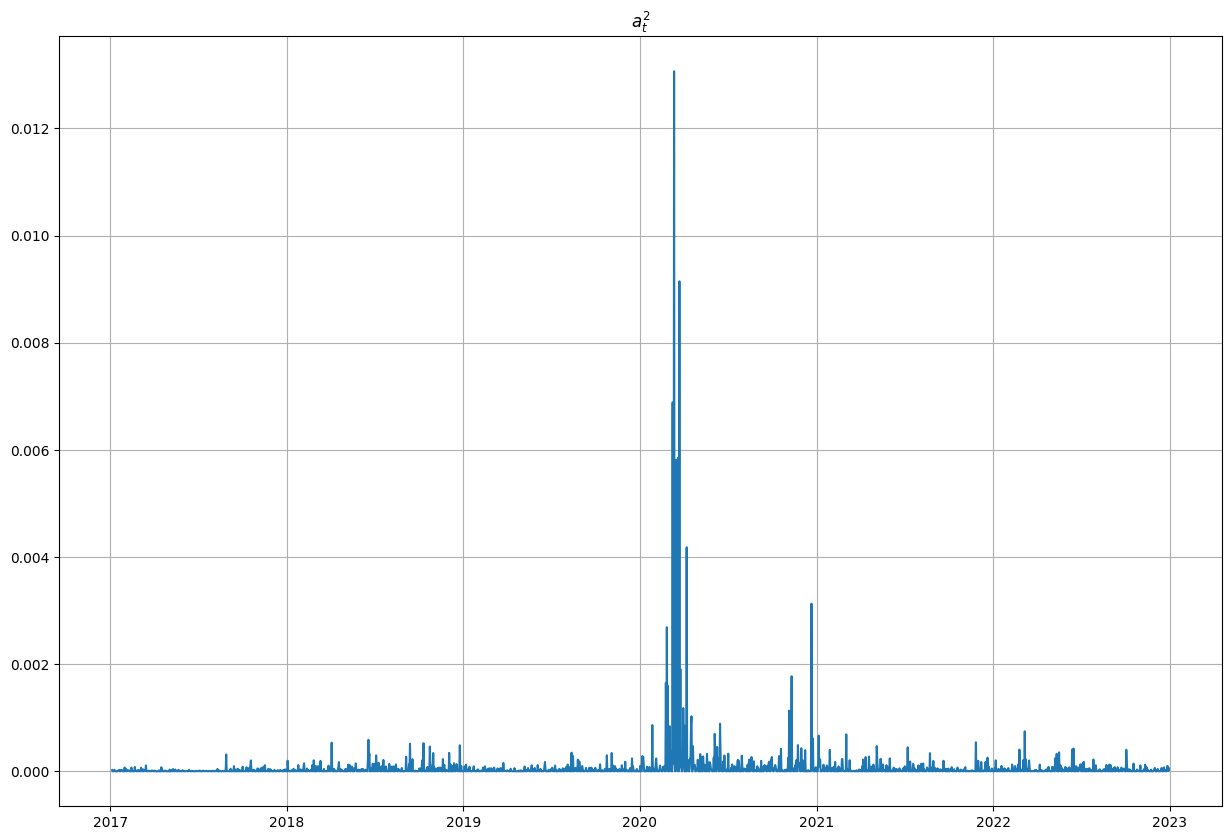

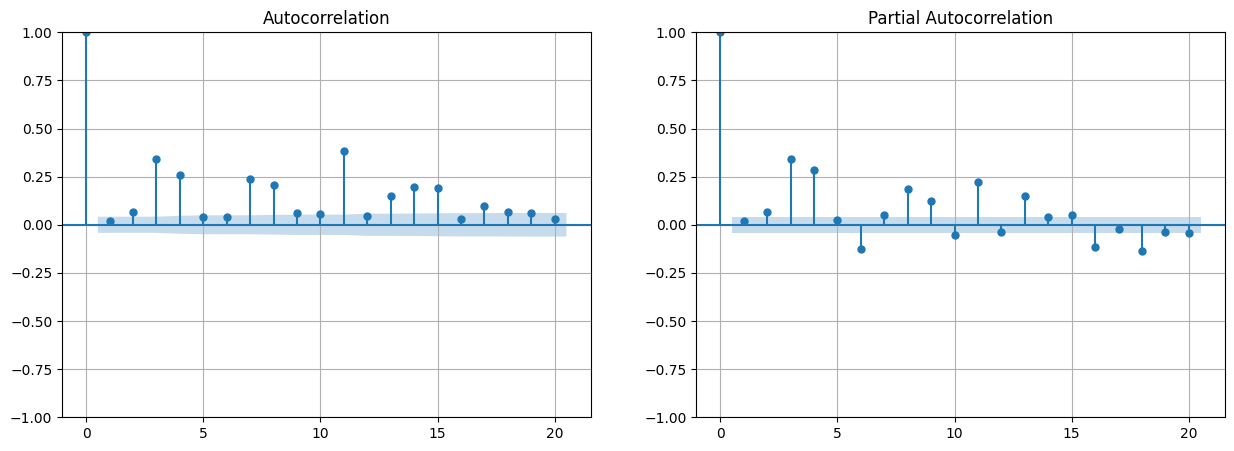

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
mu = detrend.mean()
print(f"mean: {mu:0.3f}")
a_t = detrend - mu
a_sq = (a_t) ** 2
fig = plt.figure(figsize=(15,10))
plt.plot(a_sq)
plt.grid()
plt.title(r"$a^2_t$")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plot_acf(x=a_sq,ax=axes[0], lags=20)
axes[0].grid()
plot_pacf(x=a_sq,ax=axes[1], lags=20)
axes[1].grid()

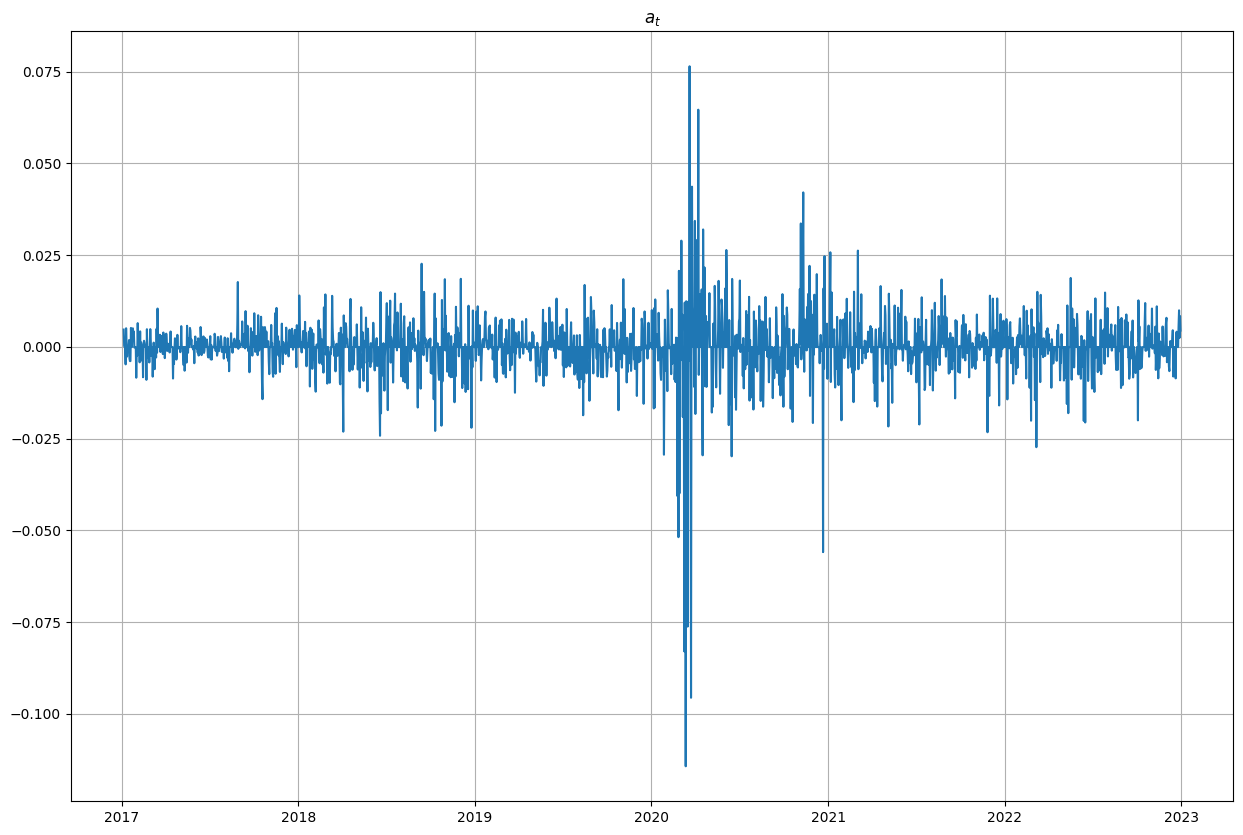

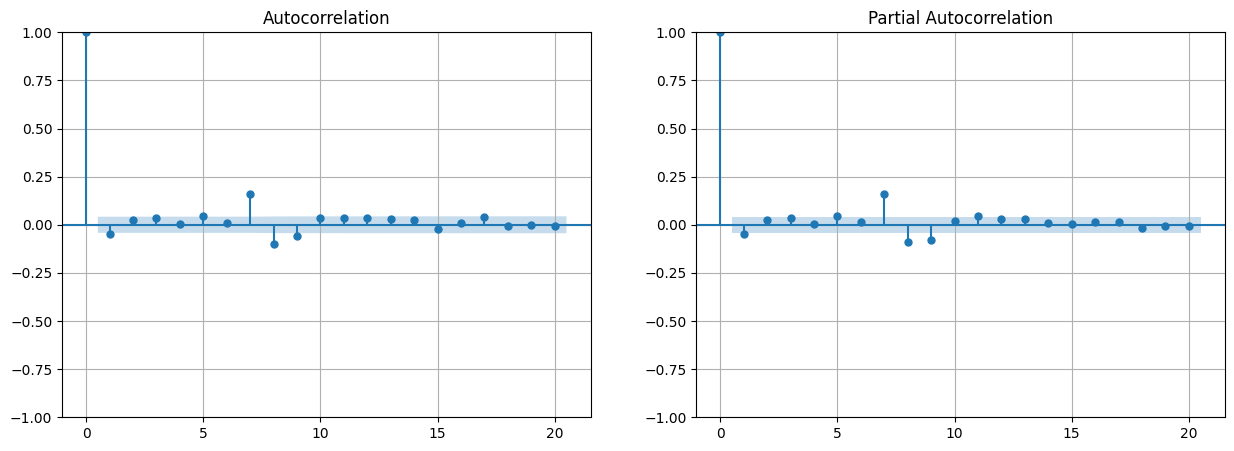

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.plot(a_t)
plt.grid()
plt.title(r"$a_t$")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plot_acf(x=a_t,ax=axes[0], lags=20)
axes[0].grid()
plot_pacf(x=a_t,ax=axes[1], lags=20)
axes[1].grid()

From the PACF plot of $a^2_t$, I decided to use ARCH with $p=6$


# ARCH($p=6$)

In [ ]:
model = arch.arch_model(y=a_t*100, mean="zero",p=6,q=0, vol="arch")
split_date = "2022-01-01" # 2022 is the test year
result_arch = model.fit(disp=False,last_obs=split_date)
print(result_arch.summary())
# we forcast 100 * a_t due to scaling issue

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -1818.01
Distribution:                  Normal   AIC:                           3650.02
Method:            Maximum Likelihood   BIC:                           3688.57
                                        No. Observations:                 1822
Date:                Mon, Jan 29 2024   Df Residuals:                     1822
Time:                        05:11:25   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.2260  4.841e-02      4.668  3.042e-06    

# ARCH Forecaster

In [ ]:
arch_forecast = result_arch.forecast(horizon=5, start=split_date)

In [ ]:
arch_forecast.mean["2022-01-01":"2022-01-10"]

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2022-01-01,0.0,0.0,0.0,0.0,0.0
2022-01-02,0.0,0.0,0.0,0.0,0.0
2022-01-03,0.0,0.0,0.0,0.0,0.0
2022-01-04,0.0,0.0,0.0,0.0,0.0
2022-01-05,0.0,0.0,0.0,0.0,0.0
2022-01-06,0.0,0.0,0.0,0.0,0.0
2022-01-07,0.0,0.0,0.0,0.0,0.0
2022-01-08,0.0,0.0,0.0,0.0,0.0
2022-01-09,0.0,0.0,0.0,0.0,0.0


In [ ]:
arch_forecast.variance["2022-01-01":"2022-01-10"]

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2022-01-01,0.264112,0.306720,0.427704,0.317266,0.313973
2022-01-02,0.289386,0.410285,0.291532,0.296195,0.314708
2022-01-03,0.391292,0.272446,0.267999,0.295229,0.306115
2022-01-04,0.284462,0.280074,0.313068,0.318439,0.340501
2022-01-05,0.271184,0.304134,0.305241,0.331384,0.498320
2022-01-06,0.420571,0.422247,0.504240,0.617733,0.527952
2022-01-07,0.399582,0.481464,0.584086,0.504708,1.010304
2022-01-08,0.455238,0.557731,0.465774,0.983408,0.415960
2022-01-09,0.527853,0.435749,0.939052,0.385318,0.374907


In [ ]:
arch_forecast.residual_variance["2022-01-01":"2022-01-10"]

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2022-01-01,0.264112,0.306720,0.427704,0.317266,0.313973
2022-01-02,0.289386,0.410285,0.291532,0.296195,0.314708
2022-01-03,0.391292,0.272446,0.267999,0.295229,0.306115
2022-01-04,0.284462,0.280074,0.313068,0.318439,0.340501
2022-01-05,0.271184,0.304134,0.305241,0.331384,0.498320
2022-01-06,0.420571,0.422247,0.504240,0.617733,0.527952
2022-01-07,0.399582,0.481464,0.584086,0.504708,1.010304
2022-01-08,0.455238,0.557731,0.465774,0.983408,0.415960
2022-01-09,0.527853,0.435749,0.939052,0.385318,0.374907


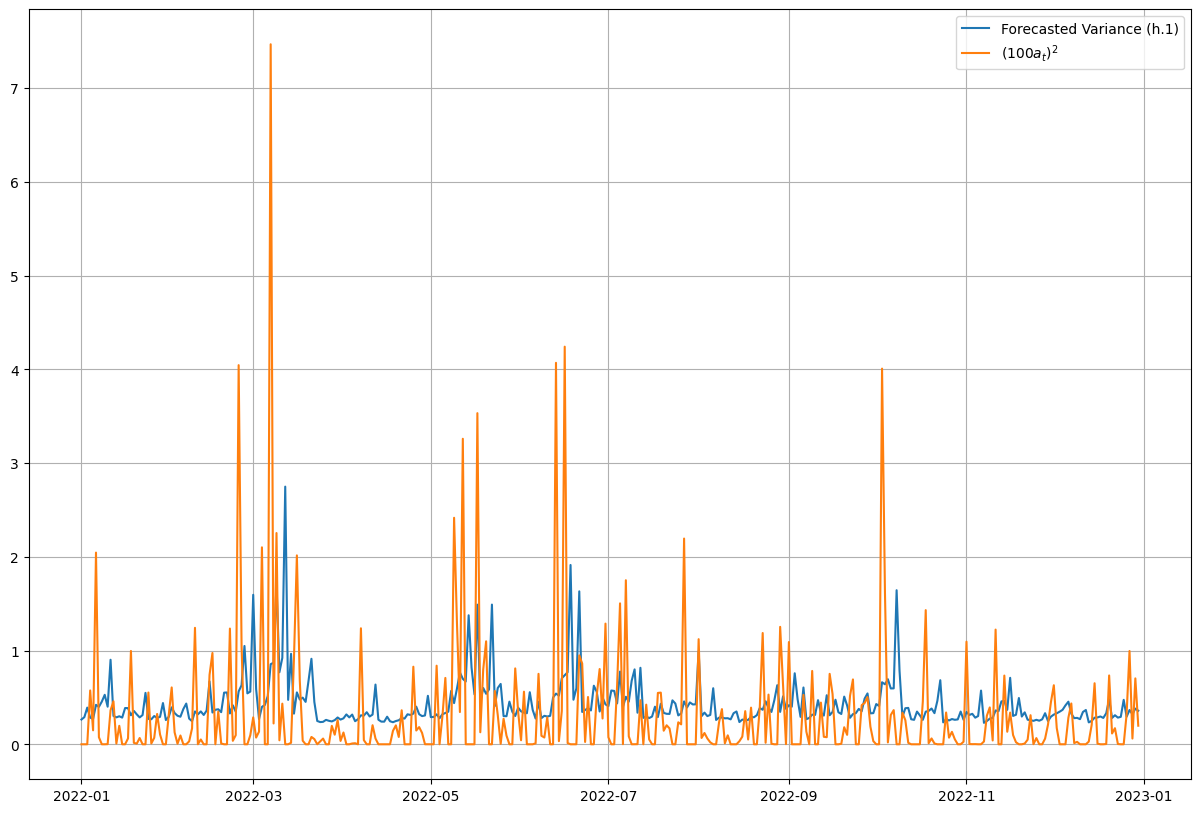

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(arch_forecast.residual_variance["h.1"], label="Forecasted Variance (h.1)")
plt.plot(1e4*a_sq[split_date:], label=f"$(100a_t)^2$")
plt.grid()
plt.legend()

#GRCH Model

In [ ]:
def buildGARCH(a_t, p_max, q_max, split_date=None):
  best_aic = np.inf
  best_result, best_model, pq = None, None, None
  for p in range(1, p_max + 1):
    for q in range(0, q_max +1):
      model = arch.arch_model(y=a_t, mean="zero", p=p, q=q, vol="GARCH")
      try:
        if split_date is not None:
          result = model.fit(disp=False, last_obs=split_date)
        else:
          result = model.fit(disp=False)
        aic = result.aic
        if aic < best_aic:
          best_aic = aic
          pq = (p,q)
          best_result = result
          best_model = model
      except:
        print(f"Cannot fit GARCH for p={p}, q={q}!!")
  return pq, best_result, best_model


#GARCH fit

In [ ]:
garch_pq, garch_result, garch_model = buildGARCH(100*a_t,
                                                 p_max=6,
                                                 q_max=6,
                                                 split_date="2022-01-01")

In [ ]:
print(f"Best pq: {garch_pq}")
print(garch_result.summary())

Best pq: (1, 6)
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1662.97
Distribution:                  Normal   AIC:                           3341.94
Method:            Maximum Likelihood   BIC:                           3386.00
                                        No. Observations:                 1822
Date:                Mon, Jan 29 2024   Df Residuals:                     1822
Time:                        05:11:27   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.9348e-03  5.875e-03      1